In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
import statsmodels.api as sm
import numpy as np
from statsmodels.api import OLS
from statsmodels.tools import add_constant

mpl.rc('font', family='Malgun Gothic')

In [3]:
!pip install linearmodels

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from linearmodels.panel import PanelOLS

In [5]:
df_population = pd.read_excel('(8개통합)행정구역_읍면동_별_5세별_주민등록인구_2011년__20240521180745_분석(전월_대비_증감,증감률).xlsx')
df_loan = pd.read_excel('예금은행 대출금리 관련 지표.xlsx')
df_grdp = pd.read_excel('GRDP_시_군_구__20240614151821.xlsx')

In [6]:
df_allpopulation = df_population[df_population['5세별'] == '계'][['행정구역(동읍면)별', '시점', '총인구수 (명)', '주택종합 매매 원데이터', '아파트 매매 원데이터', '미분양 주택 현황 원데이터']]

In [7]:
df2_grdp = df_grdp[['행정구역(동읍면)별', '시점', 'GRDP(만원)','1인당 GRDP(만원)']]
df2_grdp 

,행정구역(동읍면)별,시점,GRDP(만원),1인당 GRDP(만원)
0,서울특별시,2019-01-01,435927212,45118
1,서울특별시,2019-02-01,435927212,45118
2,서울특별시,2019-03-01,435927212,45118
3,서울특별시,2019-04-01,435927212,45118
4,서울특별시,2019-05-01,435927212,45118
...,...,...,...,...
475,양산시,2023-08-01,11893017,33489
476,양산시,2023-09-01,11893017,33489
477,양산시,2023-10-01,11893017,33489
478,양산시,2023-11-01,11893017,33489


In [13]:
m1 = pd.merge(df_allpopulation, df2_grdp, on=['시점', '행정구역(동읍면)별'], how='left')

In [14]:
df_new_loan = df_loan[['시점', '가계대출 (연리%)', '주택담보대출 (연리%)']]
final_merge = pd.merge(m1, df_new_loan, on='시점', how='left')

In [15]:
final_merge['log_총인구수'] = np.log(final_merge['총인구수 (명)'])
final_merge['log_GRDP'] = np.log(final_merge['GRDP(만원)'])
final_merge['log_1인당 GRDP'] = np.log(final_merge['1인당 GRDP(만원)'])
final_merge

,행정구역(동읍면)별,시점,총인구수 (명),주택종합 매매 원데이터,아파트 매매 원데이터,미분양 주택 현황 원데이터,GRDP(만원),1인당 GRDP(만원),가계대출 (연리%),주택담보대출 (연리%),log_총인구수,log_GRDP,log_1인당 GRDP
0,창원시,2019-01-01,1053290,95.1,91.9,6736,39860038,38153,3.58,3.12,13.867429,17.500885,10.549360
1,창원시,2019-02-01,1052458,94.8,91.5,6773,39860038,38153,3.50,3.08,13.866639,17.500885,10.549360
2,창원시,2019-03-01,1051118,94.4,91.1,6750,39860038,38153,3.53,3.04,13.865365,17.500885,10.549360
3,창원시,2019-04-01,1049897,94.0,90.6,5892,39860038,38153,3.48,2.98,13.864203,17.500885,10.549360
4,창원시,2019-05-01,1049052,93.5,90.0,5892,39860038,38153,3.49,2.93,13.863397,17.500885,10.549360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,양산시,2023-08-01,354877,94.7,93.6,482,11893017,33489,4.83,4.31,12.779527,16.291462,10.418972
476,양산시,2023-09-01,355032,94.6,93.6,476,11893017,33489,4.90,4.35,12.779963,16.291462,10.418972
477,양산시,2023-10-01,355136,94.6,93.6,471,11893017,33489,5.04,4.56,12.780256,16.291462,10.418972
478,양산시,2023-11-01,355270,94.5,93.5,465,11893017,33489,5.04,4.48,12.780633,16.291462,10.418972


In [16]:
# 최종 병합 데이터 패널자료화 
final_merge = final_merge.set_index(['행정구역(동읍면)별', '시점'])
final_merge.to_excel('final_panel_data.xlsx')

In [17]:
# 변수 설정
Y = final_merge['아파트 매매 원데이터']
X = final_merge[['log_총인구수', 'log_1인당 GRDP', '가계대출 (연리%)', '주택담보대출 (연리%)', '미분양 주택 현황 원데이터']]

In [18]:
# X 데이터에 상수항 추가
X = sm.add_constant(X)

In [19]:
# 패널 회귀 분석 수행
model = PanelOLS(Y, X, entity_effects=True)
results = model.fit()

In [20]:
# 회귀 분석 결과 출력
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:            아파트 매매 원데이터   R-squared:                        0.6227
Estimator:                   PanelOLS   R-squared (Between):          -1.277e+04
No. Observations:                 480   R-squared (Within):               0.6227
Date:                Thu, Jun 20 2024   R-squared (Overall):             -1065.8
Time:                        04:39:47   Log-likelihood                   -1297.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      154.14
Entities:                           8   P-value                           0.0000
Avg Obs:                       60.000   Distribution:                   F(5,467)
Min Obs:                       60.000                                           
Max Obs:                       60.000   F-statistic (robust):             154.14
                            

In [21]:
# 다중공선성 검토
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [22]:
X_vif = final_merge[['log_총인구수', 'log_1인당 GRDP', '가계대출 (연리%)', '주택담보대출 (연리%)', '미분양 주택 현황 원데이터']]

In [23]:
# 다중공선성 계산(VIF 계산)
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

In [25]:
vif_data

,feature,VIF
0,log_총인구수,159.263337
1,log_1인당 GRDP,182.209572
2,가계대출 (연리%),470.053116
3,주택담보대출 (연리%),501.255291
4,미분양 주택 현황 원데이터,1.991315


In [26]:
correlation_matrix = pd.concat([X, Y], axis=1).corr()

In [27]:
# 다중공선성의 문제가 있을 수 있다(총인구수와 GRDP)
correlation_matrix

,const,log_총인구수,log_1인당 GRDP,가계대출 (연리%),주택담보대출 (연리%),미분양 주택 현황 원데이터,아파트 매매 원데이터
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log_총인구수,NaN,1.000000,0.358493,-0.007480,-0.007799,0.128567,-0.150974
log_1인당 GRDP,NaN,0.358493,1.000000,0.169198,0.174272,0.076419,-0.061425
가계대출 (연리%),NaN,-0.007480,0.169198,1.000000,0.979456,-0.015042,0.285870
주택담보대출 (연리%),NaN,-0.007799,0.174272,0.979456,1.000000,-0.090292,0.406697
미분양 주택 현황 원데이터,NaN,0.128567,0.076419,-0.015042,-0.090292,1.000000,-0.479862
아파트 매매 원데이터,NaN,-0.150974,-0.061425,0.285870,0.406697,-0.479862,1.000000


In [28]:
final_merge['잔차'] = results.resids

C:\Users\a0108\AppData\Local\Temp\ipykernel_14644\4226093976.py:8: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('Histogram of Residuals.png')
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


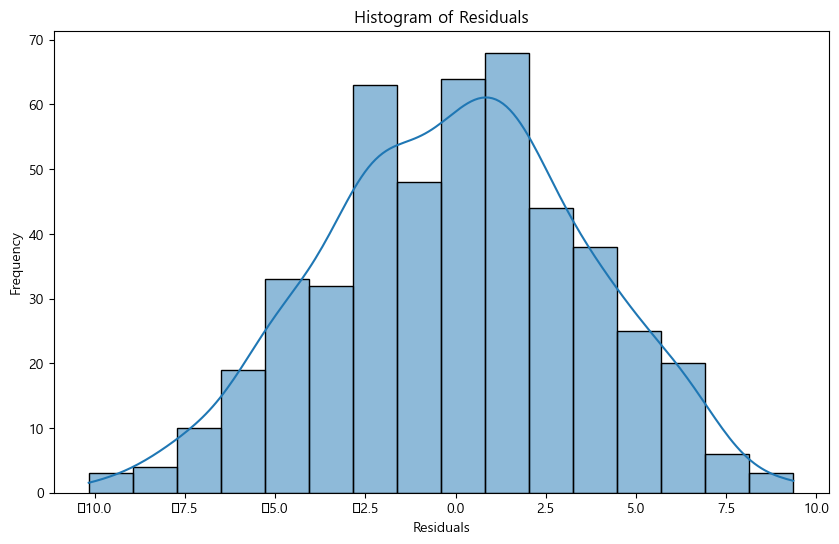

In [43]:
# 잔차의 히스토그램 (정규성 검토)
plt.figure(figsize=(10, 6))
sns.histplot(final_merge['잔차'], kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.savefig('Histogram of Residuals.png')

In [30]:
# 잔차를 통해 독립성과 등분산성 검토
data = pd.concat([X, Y], axis=1)
data

const   log_총인구수  log_1인당 GRDP  가계대출 (연리%)  \
행정구역(동읍면)별 시점                                                       
창원시        2019-01-01    1.0  13.867429     10.549360        3.58   
           2019-02-01    1.0  13.866639     10.549360        3.50   
           2019-03-01    1.0  13.865365     10.549360        3.53   
           2019-04-01    1.0  13.864203     10.549360        3.48   
           2019-05-01    1.0  13.863397     10.549360        3.49   
...                      ...        ...           ...         ...   
양산시        2023-08-01    1.0  12.779527     10.418972        4.83   
           2023-09-01    1.0  12.779963     10.418972        4.90   
           2023-10-01    1.0  12.780256     10.418972        5.04   
           2023-11-01    1.0  12.780633     10.418972        5.04   
           2023-12-01    1.0  12.780217     10.418972        4.82   

                       주택담보대출 (연리%)  미분양 주택 현황 원데이터  아파트 매매 원데이터  
행정구역(동읍면)별 시점                                                     
창원시        2019-01-01          3.12            6736         91.9  
           2019-02-01          3.08            6773         91.5  
           2019-03-01          3.04            6750         91.1  
           2019-04-01          2.98            5892         90.6  
           2019-05-01          2.93            5892         90.0  
...                             ...             ...          ...  
양산시        2023-08-01          4.31             482         93.6  
           2023-09-01          4.35             476         93.6  
           2023-10-01          4.56             471         93.6  
           2023-11-01          4.48             465         93.5  
           2023-12-01          4.16             462         93.3  

[480 rows x 7 columns]

In [31]:
data = data.dropna()

In [32]:
# 결측치를 제거한 후 다시 X와 y로 분리
X = data.drop(columns='아파트 매매 원데이터')
y = data['아파트 매매 원데이터']

In [33]:
X = add_constant(X)
model = OLS(y, X).fit()

In [34]:
# 예측값과 잔차 계산
predictions = model.fittedvalues
residuals = y - predictions

C:\Users\a0108\AppData\Local\Temp\ipykernel_14644\2718590292.py:9: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('Residual independence, equal variance.png')
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


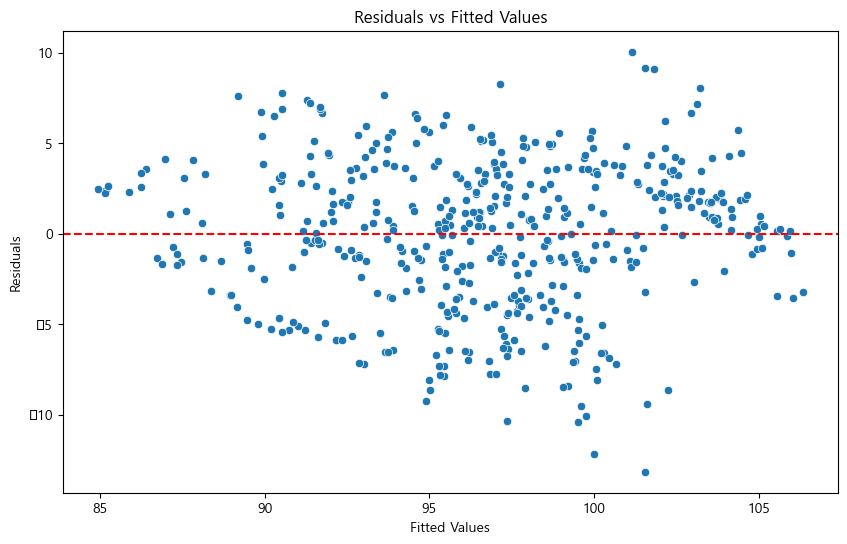

In [44]:
# 잔차 vs. 예측값 산점도 (독립성, 등분산성 검토)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.savefig('Residual independence, equal variance.png')

In [36]:
# 주택 종합 매매 가격 지수 회귀 분석 수행 (동일 과정)
Y2 = final_merge['주택종합 매매 원데이터']
X2 = final_merge[['log_총인구수', 'log_1인당 GRDP', '가계대출 (연리%)', '주택담보대출 (연리%)', '미분양 주택 현황 원데이터']]

In [37]:
X2 = sm.add_constant(X2)

In [39]:
model2 = PanelOLS(Y2, X2, entity_effects=True)
results2 = model2.fit()

In [40]:
print(results2.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:           주택종합 매매 원데이터   R-squared:                        0.6164
Estimator:                   PanelOLS   R-squared (Between):          -1.995e+04
No. Observations:                 480   R-squared (Within):               0.6164
Date:                Thu, Jun 20 2024   R-squared (Overall):             -1481.0
Time:                        05:05:01   Log-likelihood                   -1185.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      150.10
Entities:                           8   P-value                           0.0000
Avg Obs:                       60.000   Distribution:                   F(5,467)
Min Obs:                       60.000                                           
Max Obs:                       60.000   F-statistic (robust):             150.10
                            

In [45]:
final_merge['잔차2'] = results2.resids

C:\Users\a0108\AppData\Local\Temp\ipykernel_14644\1059662145.py:8: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('Histogram2 of Residuals.png')
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


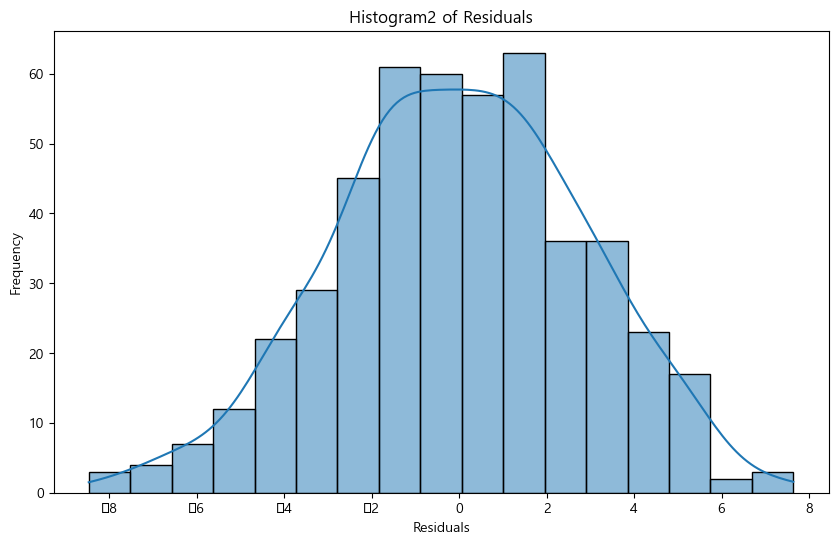

In [46]:
# 잔차의 히스토그램 (정규성 검토)
plt.figure(figsize=(10, 6))
sns.histplot(final_merge['잔차2'], kde=True)
plt.title('Histogram2 of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.savefig('Histogram2 of Residuals.png')

In [47]:
# 잔차를 통해 독립성과 등분산성 검토
data2 = pd.concat([X2, Y2], axis=1)
data2

const   log_총인구수  log_1인당 GRDP  가계대출 (연리%)  \
행정구역(동읍면)별 시점                                                       
창원시        2019-01-01    1.0  13.867429     10.549360        3.58   
           2019-02-01    1.0  13.866639     10.549360        3.50   
           2019-03-01    1.0  13.865365     10.549360        3.53   
           2019-04-01    1.0  13.864203     10.549360        3.48   
           2019-05-01    1.0  13.863397     10.549360        3.49   
...                      ...        ...           ...         ...   
양산시        2023-08-01    1.0  12.779527     10.418972        4.83   
           2023-09-01    1.0  12.779963     10.418972        4.90   
           2023-10-01    1.0  12.780256     10.418972        5.04   
           2023-11-01    1.0  12.780633     10.418972        5.04   
           2023-12-01    1.0  12.780217     10.418972        4.82   

                       주택담보대출 (연리%)  미분양 주택 현황 원데이터  주택종합 매매 원데이터  
행정구역(동읍면)별 시점                                                      
창원시        2019-01-01          3.12            6736          95.1  
           2019-02-01          3.08            6773          94.8  
           2019-03-01          3.04            6750          94.4  
           2019-04-01          2.98            5892          94.0  
           2019-05-01          2.93            5892          93.5  
...                             ...             ...           ...  
양산시        2023-08-01          4.31             482          94.7  
           2023-09-01          4.35             476          94.6  
           2023-10-01          4.56             471          94.6  
           2023-11-01          4.48             465          94.5  
           2023-12-01          4.16             462          94.4  

[480 rows x 7 columns]

In [48]:
data2 = data2.dropna()

# 결측치를 제거한 후 다시 X와 y로 분리
X2 = data2.drop(columns='주택종합 매매 원데이터')
y2 = data2['주택종합 매매 원데이터']

In [49]:
X2 = add_constant(X2)
model = OLS(y2, X2).fit()

In [50]:
# 예측값과 잔차 계산
predictions2 = model.fittedvalues
residuals2 = y2 - predictions

C:\Users\a0108\AppData\Local\Temp\ipykernel_14644\3602370249.py:9: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('Residual2 independence, equal variance.png')
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


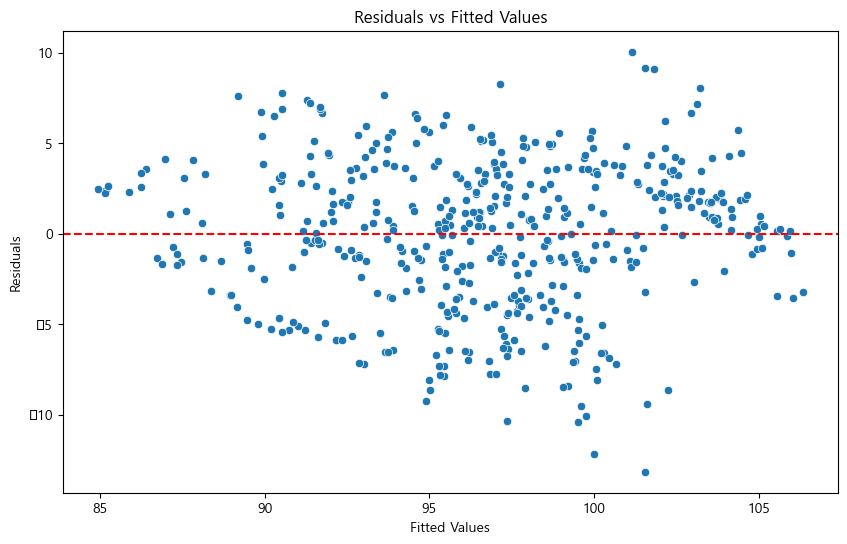

In [51]:
# 잔차 vs. 예측값 산점도 (독립성, 등분산성 검토)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.savefig('Residual2 independence, equal variance.png')